# Homework 3
### Marco Sicklinger, April 2021

## Prerequisites: modules & definitions


In [66]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from scripts import mnist

### Accuracy function

In [67]:
def accuracy(y_hat, y):
    '''
    Accuracy function implemented during lab
    '''
    classes_prediction = y_hat.argmax(dim=1)
    match_ground_truth = classes_prediction == y
    correct_matches = match_ground_truth.sum()
    return (correct_matches / y_hat.shape[0]).item()

### Average meter class

In [68]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### Model class

In [69]:
class MNIST_MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super().__init__()
        self.flat = nn.Flatten()
        self.h1 = nn.Linear(28*28, 16)
        self.h2 = nn.Linear(16, 32)
        self.h3 = nn.Linear(32, 24)
        self.out = nn.Linear(24, 10)
    
    def forward(self, X, activ_hidden=nn.functional.relu):
        out = self.flat(X)
        out = activ_hidden(self.h1(out))
        out = activ_hidden(self.h2(out))
        out = activ_hidden(self.h3(out))
        out = self.out(out)
        return out

### Data

In [70]:
minibatch_size_train = 256
minibatch_size_test = 512

trainloader, testloader, trainset, testset = mnist.get_data(batch_size_train=minibatch_size_test, batch_size_test=minibatch_size_test)

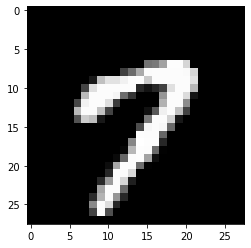

In [71]:
_ = plt.imshow(trainset.data[15].numpy(), cmap="gray")

### Criterion

In [72]:
criterion = nn.CrossEntropyLoss()

## Assignment 1
The custom loss function for the L1 norm regularization can be defined as follows.

In [73]:
def loss_ReL1(model, decay = .1, loss_ft = None):
    if loss_ft is None:
        return None
    
    L1_norms = [par.norm(1).item() for name, par in model.named_parameters() if 'weight' in name]
    shapes = [[par.shape[0],par.shape[1]] for name, par in model.named_parameters() if 'weight' in name]
    return loss_ft + decay*sum(L1_norms)/shapes[0][1]

A word of caution: if the user who implements the `model` names every layer with labels containing the word "weight", the function ends up adding also the biases' norms to the regularization term.

## Testing: L1 norm regularization

### Training function

In [111]:
def training_L1reg(model, criterion, optimizer, trainloader, epochs = 20):
    # creating container for saving loss and accuracy measurments
    performance_training = [[None],[None]]

    for i in range(epochs):
        print('\n')
        print('Epoch {}\n'.format(i+1))

        ############
        # TRAINING #
        ############
        loss_meter_train = AverageMeter()
        accuracy_meter_train = AverageMeter()
        model.train()
        for X, y in trainloader:
            optimizer.zero_grad()
            y_hat = model(X)
            loss = loss_ReL1(model, loss_ft = criterion(y_hat, y))
            loss.backward()
            optimizer.step()
            acc = accuracy(y_hat, y)
            loss_meter_train.update(val=loss.item(), n=X.shape[0])
            accuracy_meter_train.update(val=acc, n=X.shape[0])
        print('TRAINING loss {:.3f} (avg {:.3f}) - TRAINING accuracy {:.3f}\n'.format(loss_meter_train.sum, loss_meter_train.avg, accuracy_meter_train.avg))
        performance_training[0].append(loss_meter_train.avg)
        performance_training[1].append(accuracy_meter_train.avg)

    return performance_training

### Model & optimizer

In [112]:
model = MNIST_MultiLayerPerceptron()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
num_epochs = 100

### Training

In [113]:
performance_training = training_L1reg(model, criterion, optimizer, trainloader, testloader, epochs = num_epochs)



Epoch 1

TRAINING loss 78823.325 (avg 1.314) - TRAINING accuracy 0.574



Epoch 2

TRAINING loss 30570.903 (avg 0.510) - TRAINING accuracy 0.866



Epoch 3

TRAINING loss 23323.636 (avg 0.389) - TRAINING accuracy 0.904



Epoch 4

TRAINING loss 19904.086 (avg 0.332) - TRAINING accuracy 0.920



Epoch 5

TRAINING loss 18228.321 (avg 0.304) - TRAINING accuracy 0.930



Epoch 6

TRAINING loss 17126.023 (avg 0.285) - TRAINING accuracy 0.936



Epoch 7

TRAINING loss 16402.275 (avg 0.273) - TRAINING accuracy 0.940



Epoch 8

TRAINING loss 15795.934 (avg 0.263) - TRAINING accuracy 0.945



Epoch 9

TRAINING loss 15298.432 (avg 0.255) - TRAINING accuracy 0.947



Epoch 10

TRAINING loss 14808.058 (avg 0.247) - TRAINING accuracy 0.950



Epoch 11

TRAINING loss 14456.225 (avg 0.241) - TRAINING accuracy 0.952



Epoch 12

TRAINING loss 14305.989 (avg 0.238) - TRAINING accuracy 0.953



Epoch 13

TRAINING loss 13976.022 (avg 0.233) - TRAINING accuracy 0.955



Epoch 14

TRAINING loss 13784.62

### Plots

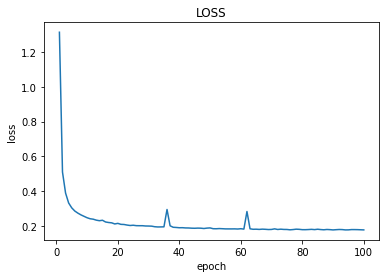

In [114]:
axis = [i for i in range(num_epochs+1)]
_ = plt.plot(axis, performance_training[0])
__ = plt.xlabel('epoch') 
___ = plt.ylabel('loss')
____ = plt.title('LOSS')

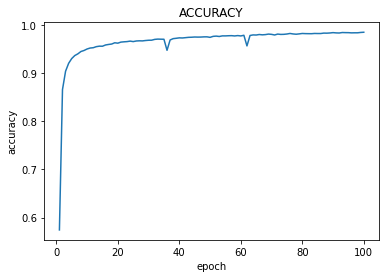

In [116]:
axis = [i for i in range(num_epochs+1)]
_ = plt.plot(axis, performance_training[1])
__ = plt.xlabel('epoch') 
___ = plt.ylabel('accuracy')
____ = plt.title('ACCURACY')

## Assignment 2

Early stopping can be implemented as a function object as follows

In [97]:
class EarlyStopping:
    """
    Early stopping procedure
    """

    def __init__(self, wordy = False, tolerance = .5, saving_path = 'early_stopping.pt', messenger = print):
        """
        Members
        -------
        _wordy: bool
                boolean for printing (True) or not (False) updates
        _path:  str
                string indicating where to save best model
        _messenger: function
                    function used to print class messages
        _tolerance: Number
                    maximum allowed change in generalized loss 
        _min:   Number
                variable for saving the best loss computed up to current epoch
        _generalized_loss:  Number
                            variable for saving the change in loss function from previous to current step
        steps: Number
                number of epochs completed before early stopping
        early_stop: bool
                    boolean set to `True` if threshold is reached, `False` otherwise

        Parameters
        ----------
        wordy:  bool
                boolean passed as `True` if class messages are requested, `False` otherwise
        saving_path:    str
                        string indicating a path where to save best model
        messenger:  function
                    function used to print class messages 
        """
        
        self._wordy = wordy
        self._path = saving_path
        self._messenger = messenger
        self._tolerance = tolerance
        self._min = np.Inf
        self._generalized_loss = 0
        self.steps = 0
        self.early_stop = False

    def __call__(self, loss, model):
        """
        Parameters
        ----------
        loss:   Number
                computed loss function at current epoch
        model:  Class[torch.nn.Module]
                model used for learning
        """

        self.steps += 1

        # if loss decreases update minimum and save.
        if loss < self._min:
            if self._wordy:
                self._messenger('early_stopping class message: good step - generalized loss {:.3f}'.format(self.generalized_loss(loss, self._min)))
            self._min = loss
            self.save_model(loss, model)
        # if tolerance is reached, set member `early_stop` to `True`
        # so to allow the user to stop the procedure
        elif loss >= self._min:
            gen_loss = self.generalized_loss(loss, self._min)
            if self._wordy:
                self._messenger('early_stopping class message: bad step - generalized loss {:.3f}'.format(gen_loss))
            if gen_loss > self._tolerance:
                self.early_stop = True

    def save_model(self, loss, model):
        """
        Function for saving the model

        Parameters
        ----------
        loss:   Number
                computed loss function at current epoch
        model:  Class[torch.nn.Module]
                model used for learning
        """

        torch.save(model.state_dict(), self._path)

    def generalized_loss(self, loss, Min):
        """
        Function for computing the generalized loss

        Parameters
        ----------
        loss:   Number
                computed loss function
        Min:    Number
                minimum loss function computed up to current epoch
        """
        return loss/Min-1

## Testing: early stopping

### Training function

In [98]:
def training_early(model, criterion, optimizer, trainloader, validloader, epochs = 20):
    # creating container for saving loss and accuracy measurments
    performance_training = [[None],[None]]
    performance_validation = [[None],[None]]
    # creating early stopping object
    early_stopping = EarlyStopping(wordy = True, tolerance = 1)

    for i in range(epochs):
        print('\n')
        print('Epoch {}\n'.format(i+1))

        ############
        # TRAINING #
        ############
        loss_meter_train = AverageMeter()
        accuracy_meter_train = AverageMeter()
        model.train()
        for X, y in trainloader:
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            acc = accuracy(y_hat, y)
            loss_meter_train.update(val=loss.item(), n=X.shape[0])
            accuracy_meter_train.update(val=acc, n=X.shape[0])
        print('TRAINING loss {:.3f} (avg {:.3f}) - TRAINING accuracy {:.3f}\n'.format(loss_meter_train.sum, loss_meter_train.avg, accuracy_meter_train.avg))
        performance_training[0].append(loss_meter_train.sum)
        performance_training[1].append(accuracy_meter_train.avg)

        ##############
        # VALIDATION #
        ##############
        loss_meter_valid = AverageMeter()
        accuracy_meter_valid = AverageMeter()
        model.eval()
        for X, y in validloader:
            y_hat = model(X)
            loss = criterion(y_hat, y)
            acc = accuracy(y_hat, y)
            loss_meter_valid.update(val=loss.item(), n=X.shape[0])
            accuracy_meter_valid.update(val=acc, n=X.shape[0])
        print('VALIDATION loss {:.3f} (avg {:.3f}) - VALIDATION accuracy {:.3f}\n'.format(loss_meter_valid.sum, loss_meter_valid.avg, accuracy_meter_valid.avg))
        performance_validation[0].append(loss_meter_valid.sum)
        performance_validation[1].append(accuracy_meter_valid.avg)

        early_stopping(loss_meter_valid.sum, model)

        if early_stopping.early_stop:
            print('##################')
            print('# EARLY STOPPING #')
            print('##################')
            model.load_state_dict(torch.load('early_stopping.pt'))
            break

    return performance_training, performance_validation, early_stopping.steps

### Model & optimizer

In [99]:
model = MNIST_MultiLayerPerceptron()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [100]:
num_epochs = 100

### Training

In [101]:
performance_training, performance_validation, completed_epochs = training_early(model, criterion, optimizer, trainloader, testloader, epochs = num_epochs)



Epoch 1

TRAINING loss 81099.731 (avg 1.352) - TRAINING accuracy 0.544

VALIDATION loss 31830.827 (avg 0.531) - VALIDATION accuracy 0.841

early_stopping class message: good step - generalized loss -1.000


Epoch 2

TRAINING loss 25234.091 (avg 0.421) - TRAINING accuracy 0.873

VALIDATION loss 20747.761 (avg 0.346) - VALIDATION accuracy 0.898

early_stopping class message: good step - generalized loss -0.348


Epoch 3

TRAINING loss 19214.131 (avg 0.320) - TRAINING accuracy 0.904

VALIDATION loss 16927.559 (avg 0.282) - VALIDATION accuracy 0.917

early_stopping class message: good step - generalized loss -0.184


Epoch 4

TRAINING loss 16067.702 (avg 0.268) - TRAINING accuracy 0.920

VALIDATION loss 17608.440 (avg 0.293) - VALIDATION accuracy 0.911

early_stopping class message: bad step - generalized loss 0.040


Epoch 5

TRAINING loss 14106.041 (avg 0.235) - TRAINING accuracy 0.929

VALIDATION loss 13801.642 (avg 0.230) - VALIDATION accuracy 0.932

early_stopping class message: goo

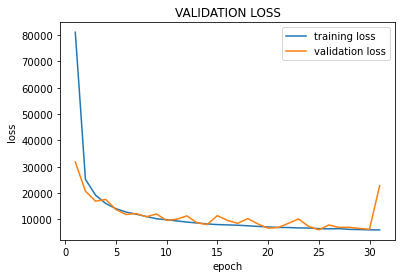

In [102]:
axis = [i for i in range(completed_epochs+1)]
_ = plt.plot(axis, performance_training[0], label = 'training loss')
__ = plt.xlabel('epoch') 
___ = plt.ylabel('loss')
____ = plt.title('TRAINING LOSS')
_ = plt.plot(axis, performance_validation[0], label = 'validation loss')
__ = plt.xlabel('epoch') 
___ = plt.ylabel('loss')
____ = plt.title('VALIDATION LOSS')
_____ = plt.legend()

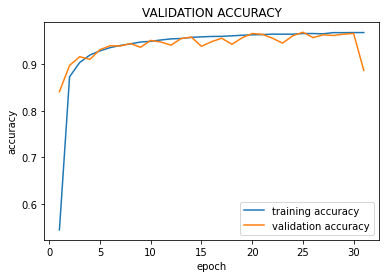

In [103]:
axis = [i for i in range(completed_epochs+1)]
_ = plt.plot(axis, performance_training[1], label = 'training accuracy')
__ = plt.xlabel('epoch') 
___ = plt.ylabel('accuracy')
____ = plt.title('TRAINING ACCURACY')
_ = plt.plot(axis, performance_validation[1], label = 'validation accuracy')
__ = plt.xlabel('epoch') 
___ = plt.ylabel('accuracy')
____ = plt.title('VALIDATION ACCURACY')
_____ = plt.legend()